# Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
* train.csv
* test.csv

#### Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

#### Целевая переменная:
Price

#### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Содержание:

In [108]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
# Следующая магическая команда Jupyter Notebook нужна для того, чтобы графики
# отображались прямо в ноутбуке, а не в отдельном окне
%matplotlib inline

# Настройка более четкого отображения графиков
%config InlineBackend.figure_format = 'svg'

# Уберем warnings
import warnings
warnings.filterwarnings('ignore')

Загружаем данные

In [83]:
# Расположение данных
TEST_DATA = './test.csv'
TRAIN_DATA = './train.csv'

In [84]:
train_data = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [85]:
train_data.shape

(10000, 20)

In [86]:
test_data = pd.read_csv(TEST_DATA, engine='python', on_bad_lines='skip')
test_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [87]:
test_data.shape

(5000, 19)

Вывод: Тренировочный датасет содержит 10000 значений, тестовый - 5000

### Рассмотрим тренировочный датасет

In [88]:
# загрузим информацию о датасете
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Описание данных <a class='anchor' id='description'>
- Id - идентификационный номер квартиры;
- DistrictId - идентификационный номер района;
- Rooms - количество комнат;
- Square - площадь;
- LifeSquare - жилая площадь;
- KitchenSquare - площадь кухни;
- Floor - этаж;
- HouseFloor - количество этажей в доме;
- HouseYear - год постройки дома;
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности;
- Social_1, Social_2, Social_3 - социальные показатели местности;
- Healtcare_1, Heltcare_2 - показатели местности, связанные с охраной здоровья;
- Shops_1, Shops_2 - показатели связанные с наличием магазинов, торговых центров;
- Price - цена квартиры.

In [89]:
# найдем пропущенные значения
train_data.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Вывод: пропущенные значения есть в двух столбцах

In [90]:
# проверим датасет на дубликаты
duplicates = train_data.duplicated()
train_data[duplicates]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Вывод: дубликатов нет

In [91]:
# посомтрим статистику по датасету
train_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Разделим признаки на численные и строковые

In [92]:
def feature_separation(df):
    num_cols = []
    str_cols = []

    cols_and_type = df.dtypes.to_dict()

    for col in cols_and_type:
        if cols_and_type[col] in ('int64', 'float64'):
            num_cols.append(col)
        else: 
            str_cols.append(col)
            
    return num_cols, str_cols

In [93]:
num_cols, str_cols = feature_separation(train_data)
f'Числовые признаки: {num_cols}'

"Числовые признаки: ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price']"

In [94]:
f'Строковые признаки: {str_cols}'

"Строковые признаки: ['Ecology_2', 'Ecology_3', 'Shops_2']"

Для удобства прочтения составим перевод признаков на основе описания данных

In [95]:
translate = {
    'Id': 'идентификационный номер квартиры',
    'DistrictId': 'идентификационный номер района',
    'Rooms': 'количество комнат',
    'Square': 'площадь',
    'LifeSquare': 'жилая площадь',
    'KitchenSquare': 'площадь кухни',
    'Floor': 'этаж',
    'HouseFloor': 'количество этажей в доме',
    'HouseYear': 'год постройки дома',
    'Ecology_1': 'экологические показатели местности_1',
    'Ecology_2': 'экологические показатели местности_2',
    'Ecology_3': 'экологические показатели местности_3',
    'Social_1': 'социальные показатели местности_1',
    'Social_2': 'социальные показатели местности_2',
    'Social_3': 'социальные показатели местности_3',
    'Healthcare_1': 'показатели местности, \nсвязанные с охраной здоровья 1',
    'Helthcare_2': 'показатели местности, \nсвязанные с охраной здоровья 2',
    'Shops_1': 'показатели связанные с наличием \n магазинов, торговых центров 1',
    'Shops_2': 'показатели связанные с наличием \nмагазинов, торговых центров 2',
    'Price': 'цена квартиры'
}

### Визуализируем числовые признаки

In [96]:
def visual_num_feature(data, captions):
    plt.figure(figsize=[11, 13])
    # Общий заголовок
    plt.suptitle(f'Распределение признаков ',
                    fontsize=16, 
                    fontweight='bold')

    for i, col in enumerate(num_cols):
        plt.subplot(6, 3, i+1)
        # Заголовок для графика
        plt.title(f'\n{col} \n({captions[col]})', fontsize=10)

        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        
        plt.hist(data[col])

        # Автоматически уместить все элементы на полотне    
    plt.tight_layout()

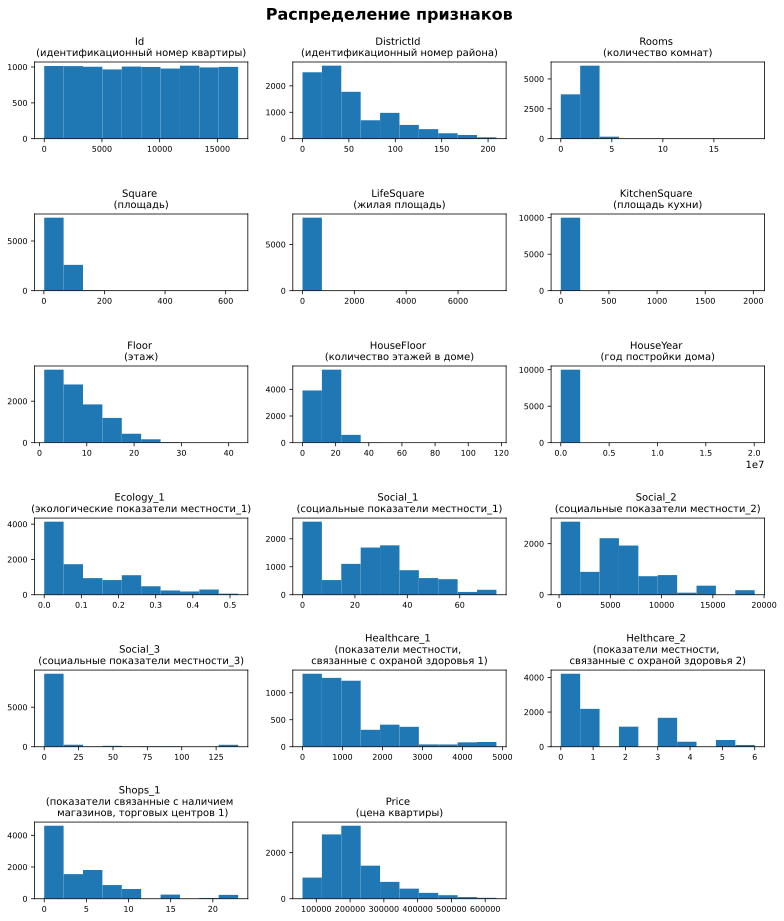

In [97]:
visual_num_feature(train_data, translate)

In [98]:
def visual_str_feature(data, captions):
    plt.figure(figsize=[11, 5])

    plt.suptitle(f'Распределение строковых признаков', 
                    fontsize=16, 
                    fontweight='bold')

    for i, col in enumerate(str_cols):
        plt.subplot(2, 3, i+1)
        plt.title(f'\n{col} \n({captions[col]})', fontsize=10)

        plt.hist(data[col], bins=2)

    plt.tight_layout()

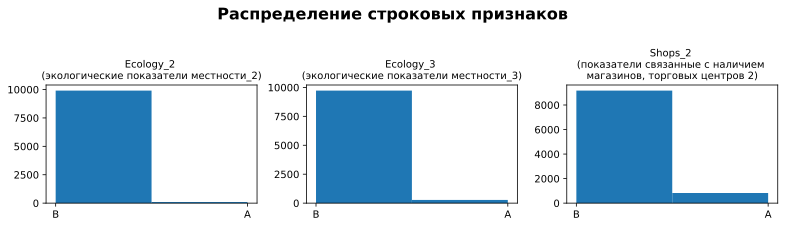

In [99]:
visual_str_feature(train_data, translate)

### Предобработка признаков

Обработка пропусков

In [100]:
train_data.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

### **LifeSquare ** - жилая площадь

In [105]:
# создадим вспомогательный признак и заполним его 1, если пропуск есть
train_data['LifeSquare_nan'] = 0
train_data.loc[train_data['LifeSquare'].isna(), 'LifeSquare_nan']
train_data.loc[train_data['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
train_data[train_data['LifeSquare_nan'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,221244.156664,1
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,229102.795999,1
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,127200.026511,1
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,...,B,30,5285,0,645.0,6,6,B,571069.052600,1
25,5073,74,2.0,82.667915,NaN,1.0,16,17.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,244145.827069,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27,1.0,38.968338,NaN,1.0,10,1.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,95529.569405,1
9986,2996,1,2.0,64.994245,NaN,1.0,9,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,200332.511658,1
9987,15623,23,2.0,55.620092,NaN,0.0,2,4.0,1977,0.034656,...,B,0,168,0,NaN,0,0,B,115797.553006,1
9994,4158,23,2.0,64.864198,NaN,1.0,17,17.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,171323.515653,1


In [112]:
train_data['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [114]:
train_data['LifeSquare'].value_counts()

1

<Axes: ylabel='LifeSquare'>

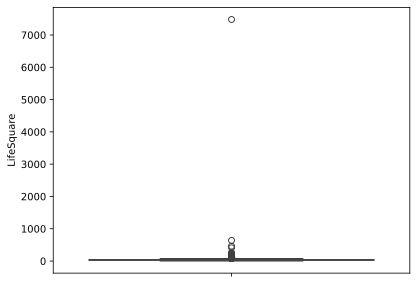

In [115]:
sns.boxplot(train_data['LifeSquare'])